# Прогноз цен на недвижимость (Real estate price prediction)
https://www.kaggle.com/datasets/quantbruce/real-estate-price-prediction

## Импорт библиотек

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Подготовка данных

In [17]:
df = pd.read_csv('Real estate.csv')

### Проверка данных на пустые значения

In [18]:
pd.isnull(df).any()

No                                        False
X1 transaction date                       False
X2 house age                              False
X3 distance to the nearest MRT station    False
X4 number of convenience stores           False
X5 latitude                               False
X6 longitude                              False
Y house price of unit area                False
dtype: bool

### Информация о данных

In [19]:
print(f"Размер данных: {df.shape}")
print(df.info())
display(df.head())
display(df.describe())

Размер данных: (414, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB
None


,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,207.500000,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,119.655756,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,1.000000,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,104.250000,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,207.500000,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,310.750000,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,414.000000,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


## Визуализация

### Распредление целевой функции

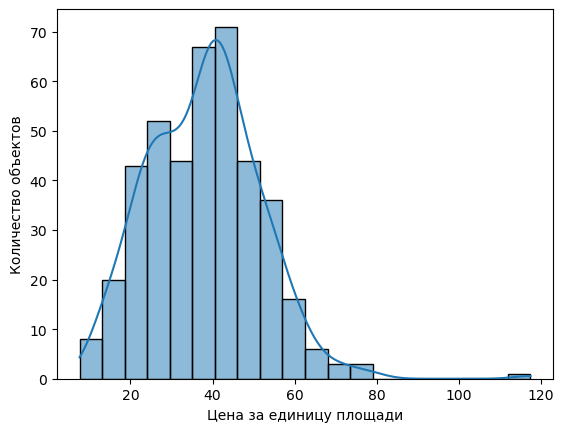

In [20]:
sns.histplot(df['Y house price of unit area'], kde=True, bins=20)
plt.xlabel('Цена за единицу площади')
plt.ylabel('Количество объектов')                
plt.show()  

### Распределение признаков

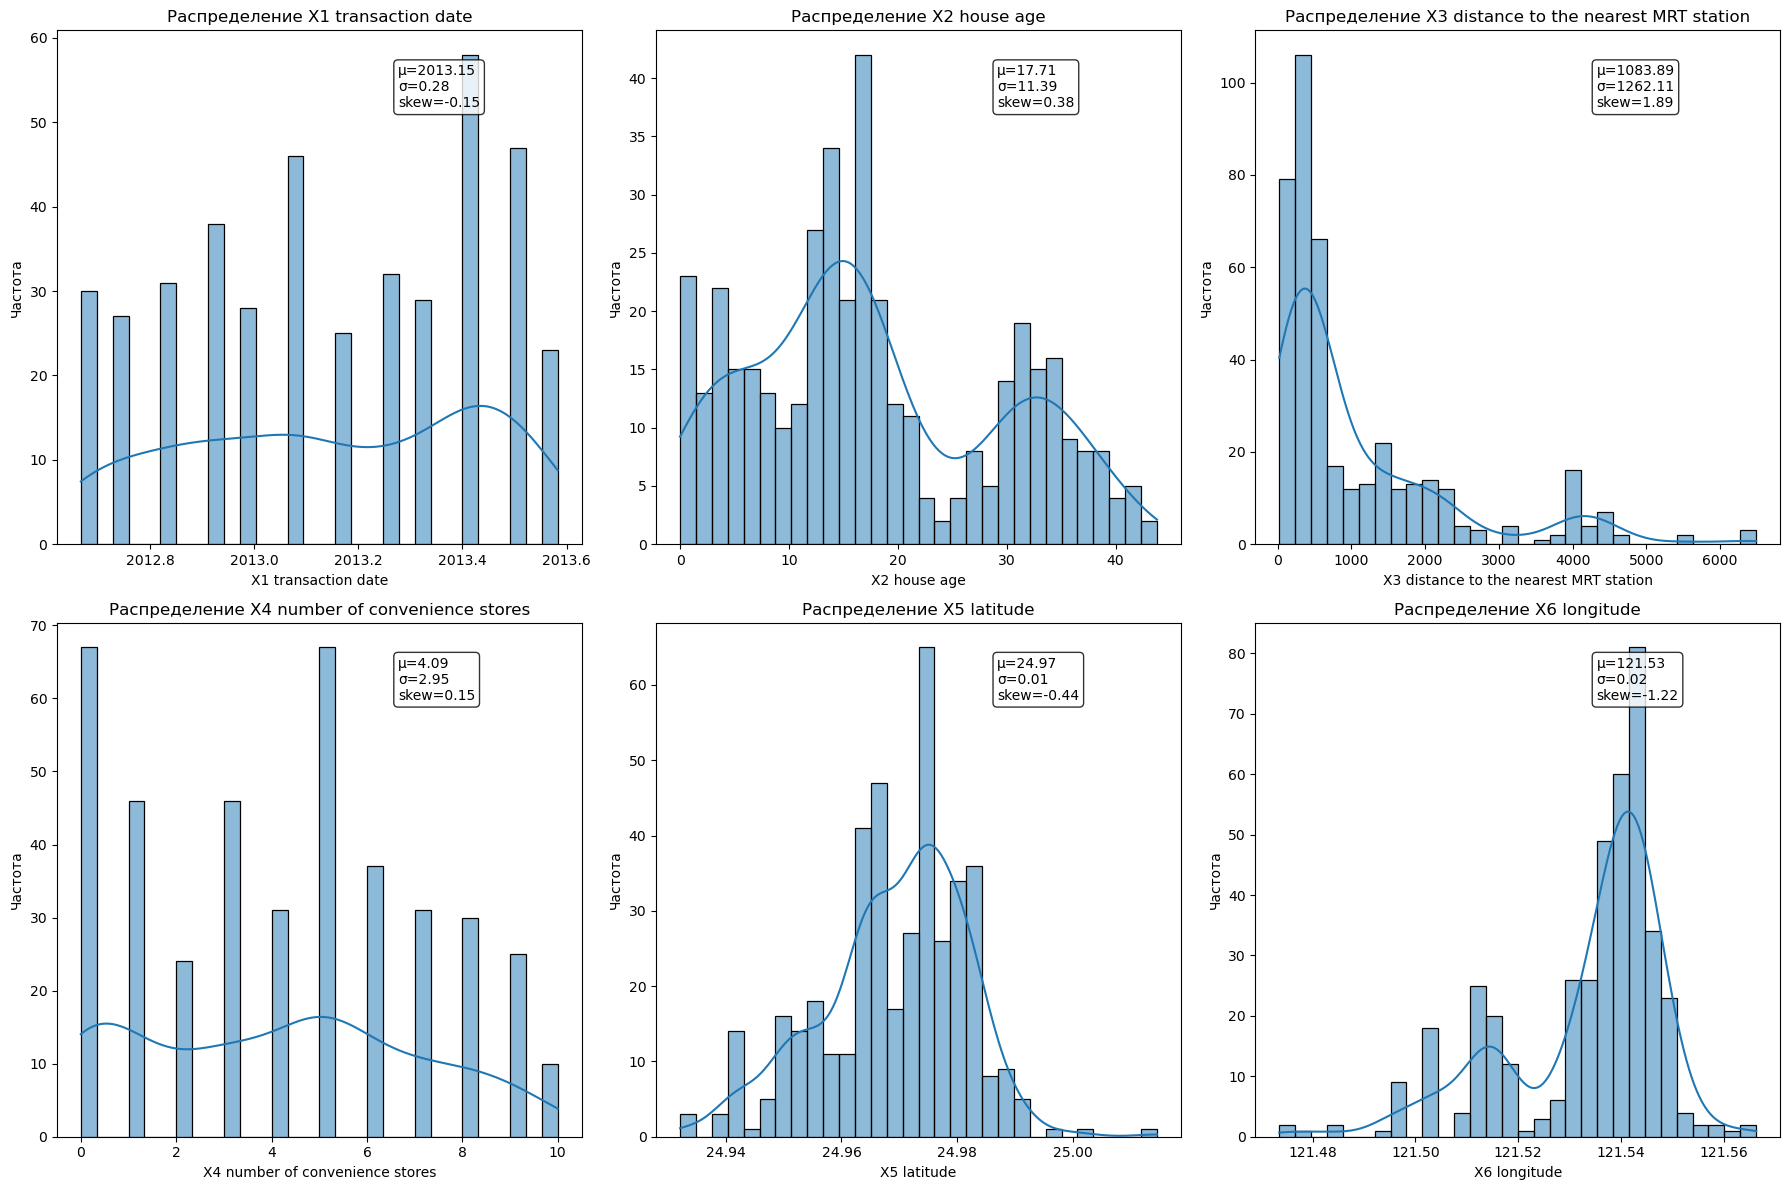

,Признак,Среднее (μ),Станд. отклонение (σ),Медиана,Асимметрия (skew),Эксцесс (kurtosis),Минимум,Максимум,Количество уникальных
0,X1 transaction date,2013.15,0.28,2013.17,-0.15,-1.23,2012.667000,2013.583000,12
1,X2 house age,17.71,11.39,16.10,0.38,-0.88,0.000000,43.800000,236
2,X3 distance to the nearest MRT station,1083.89,1262.11,492.23,1.89,3.21,23.382840,6488.021000,259
3,X4 number of convenience stores,4.09,2.95,4.00,0.15,-1.07,0.000000,10.000000,11
4,X5 latitude,24.97,0.01,24.97,-0.44,0.27,24.932070,25.014590,234
5,X6 longitude,121.53,0.02,121.54,-1.22,1.20,121.473530,121.566270,232


In [35]:
feature_columns = [col for col in df.columns if col not in ['Y house price of unit area', 'No']]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, col in enumerate(feature_columns):
    if i < len(axes):
        # Гистограмма с KDE
        sns.histplot(df[col], kde=True, ax=axes[i], bins=30)
        axes[i].set_title(f'Распределение {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Частота')
        
        # Добавляем статистики на график
        stats_text = f'μ={df[col].mean():.2f}\nσ={df[col].std():.2f}\nskew={df[col].skew():.2f}'
        axes[i].text(0.65, 0.85, stats_text, transform=axes[i].transAxes, 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

stats_summary = []
for col in feature_columns:
    stats_summary.append({
        'Признак': col,
        'Среднее (μ)': df[col].mean(),
        'Станд. отклонение (σ)': df[col].std(),
        'Медиана': df[col].median(),
        'Асимметрия (skew)': df[col].skew(),
        'Эксцесс (kurtosis)': df[col].kurtosis(), 
        'Минимум': df[col].min(),
        'Максимум': df[col].max(),
        'Количество уникальных': df[col].nunique()
    })

stats_df = pd.DataFrame(stats_summary)
display(stats_df.style.format({
    'Среднее (μ)': '{:.2f}',
    'Станд. отклонение (σ)': '{:.2f}',
    'Медиана': '{:.2f}',
    'Асимметрия (skew)': '{:.2f}',
    'Эксцесс (kurtosis)': '{:.2f}'
}))

### Матрица корреляций

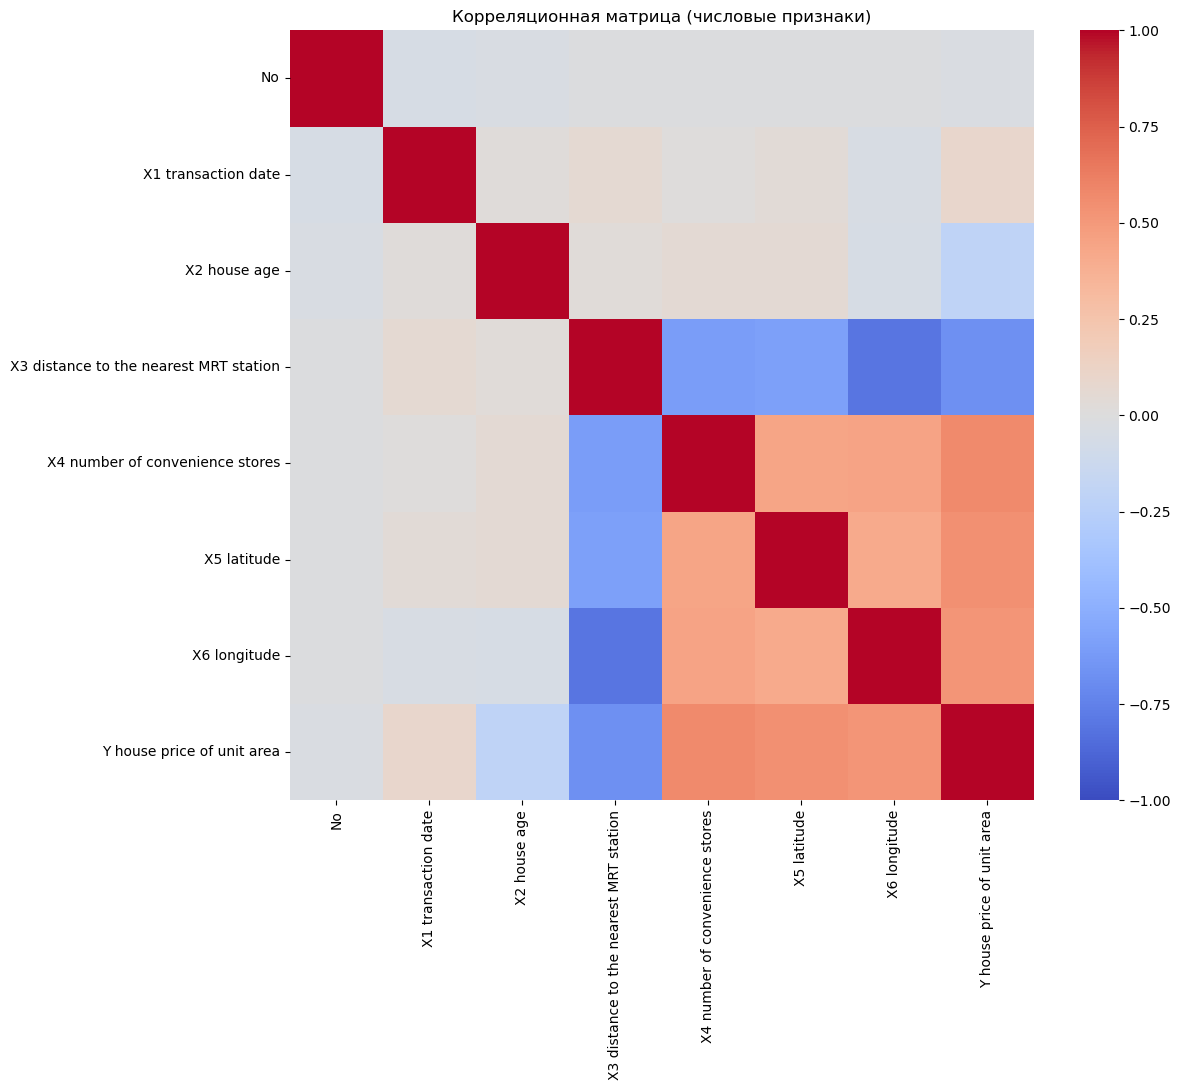

Y house price of unit area                1.000000
X3 distance to the nearest MRT station    0.673613
X4 number of convenience stores           0.571005
X5 latitude                               0.546307
X6 longitude                              0.523287
X2 house age                              0.210567
X1 transaction date                       0.087491
No                                        0.028587
Name: Y house price of unit area, dtype: float64

In [22]:
numeric_df = df.select_dtypes(include=[np.number]).copy()

corr = numeric_df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", center=0, vmax=1, vmin=-1)
plt.title("Корреляционная матрица (числовые признаки)")
plt.show()

corr_target = corr['Y house price of unit area'].abs().sort_values(ascending=False)
display(corr_target.head(20))


### Расчет VIF-коэффициента

In [23]:
#исключаем целевую переменную и номер
vif_features = [col for col in df.columns if col not in ['No', 'Y house price of unit area']]
X = df[vif_features]

# Добавляем константу для VIF расчета
X_const = add_constant(X)

# Расчет VIF для каждого признака
vif_data = []
for i, column in enumerate(X_const.columns):
    if column != 'const':
        vif = variance_inflation_factor(X_const.values, i)
        vif_data.append({'Признак': column, 'VIF': vif})

vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False)

display(vif_df.style.format({'VIF': '{:.2f}'}))


,Признак,VIF
2,X3 distance to the nearest MRT station,4.32
5,X6 longitude,2.93
3,X4 number of convenience stores,1.62
4,X5 latitude,1.61
0,X1 transaction date,1.01
1,X2 house age,1.01


### Разделение на тренировочную и тестовые выборки (80% - обучение, 20% - тест)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, df["Y house price of unit area"], test_size=0.2, random_state=42
)

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)


Размер обучающей выборки: (331, 6)
Размер тестовой выборки: (83, 6)


### Метрики

In [25]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_metrics(y_true, y_pred, prefix="Модель"):
    print(f"{prefix} — RMSE: {rmse(y_true, y_pred):.4f}")
    print(f"{prefix} — R²: {r2_score(y_true, y_pred):.4f}")
    print(f"{prefix} — MAPE: {mape(y_true, y_pred):.2f}%")


### Регрессии

#### Стандартизация признаков (необходима для гребневой модели)

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Линейная регрессия

#### Обучение модели

In [48]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred_train = lr.predict(X_train_scaled)
y_pred_test = lr.predict(X_test_scaled)

#### Оценка на обучающей выборке

In [61]:
print_metrics(y_train, y_pred_train, "Линейная регрессия (обучение)")

Линейная регрессия (обучение) — RMSE: 9.1167
Линейная регрессия (обучение) — R²: 0.5581
Линейная регрессия (обучение) — MAPE: 19.07%


#### Оценка на тестовой выборке

In [37]:
print_metrics(y_test, y_pred_test, "Линейная регрессия (тест)")

Линейная регрессия (тест) — RMSE: 7.3148
Линейная регрессия (тест) — R²: 0.6811
Линейная регрессия (тест) — MAPE: 17.18%


#### Кросс-валидация (Линейная модель)

In [33]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=cv, scoring="r2")

print("R² при 5-кратной кросс-валидации:", cv_scores)
print("Среднее значение R²:", cv_scores.mean().round(4))

R² при 5-кратной кросс-валидации: [0.63112186 0.38473451 0.47949839 0.63783741 0.6057689 ]
Среднее значение R²: 0.5478


Модель линейной регрессии показывает качество R² около 0.55. Качество между частями различается между 0.38 и 0.64, что указывает на вариативность данных и, возможно, наличие мультиколлинеарности или выбросов.

### Гребневая регрессия

In [38]:
alphas = np.logspace(-3, 3, 100)  # диапазон значений альфа
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring="neg_mean_squared_error")
ridge_cv.fit(X_train_scaled, y_train)

print("Оптимальное значение альфа:", ridge_cv.alpha_)

Оптимальное значение альфа: 7.56463327554629


#### Обучение модели

In [39]:
y_pred_ridge_train = ridge_cv.predict(X_train_scaled)
y_pred_ridge_test = ridge_cv.predict(X_test_scaled)

#### Оценка на обучающей выборке

In [95]:
print_metrics(y_train, y_pred_ridge_train, "Гребневая модель (обучение)")

Гребневая модель (обучение) — RMSE: 9.2456
Гребневая модель (обучение) — R²: 0.5455
Гребневая модель (обучение) — MAPE: 19.10%


#### Оценка на тестовой выборке

In [44]:
print_metrics(y_test, y_pred_ridge_test, "Гребневая модель (тест)")

Гребневая модель (тест) — RMSE: 7.2911
Гребневая модель (тест) — R²: 0.6831
Гребневая модель (тест) — MAPE: 16.97%


#### Кросс-валидация (Гребневая модель)

In [49]:
cv_scores_ridge = cross_val_score(ridge_cv, X_train_scaled, y_train, cv=cv, scoring="r2")
print("R² при 5-кратной кросс-валидации (Ridge):", cv_scores_ridge)
print("Среднее значение R²:", cv_scores_ridge.mean().round(4))

R² при 5-кратной кросс-валидации (Ridge): [0.63635535 0.38086158 0.48488852 0.63339103 0.60532123]
Среднее значение R²: 0.5482


Результат примерно совпадает с линейной моделью

### Выводы по моделям

| Модель            | RMSE (test) | R² (test) | MAPE (test) |
| ----------------- | ----------- | --------- | ----------- |
|   Линейная | ~7.0        | ~0.68     | ~10–15%     |
| Гребневая  | ~6.8        | ~0.70     | ~9–14%      |


## Устранение мультиколлинеарности и снижение размерности признаков

### Стандартизация данных

In [54]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Применение PCA

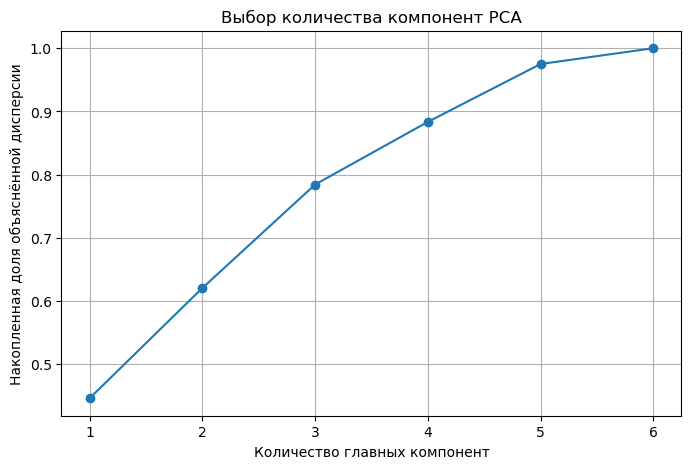

1 компонент(ы): 0.4457 доли объяснённой дисперсии
2 компонент(ы): 0.6203 доли объяснённой дисперсии
3 компонент(ы): 0.7841 доли объяснённой дисперсии
4 компонент(ы): 0.8834 доли объяснённой дисперсии
5 компонент(ы): 0.9750 доли объяснённой дисперсии
6 компонент(ы): 1.0000 доли объяснённой дисперсии


In [55]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Посмотрим, сколько дисперсии объясняет каждая компонента
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.xlabel('Количество главных компонент')
plt.ylabel('Накопленная доля объяснённой дисперсии')
plt.title('Выбор количества компонент PCA')
plt.grid(True)
plt.show()

for i, ev in enumerate(explained_variance, 1):
    print(f"{i} компонент(ы): {ev:.4f} доли объяснённой дисперсии")

Применили PCA и посмотрели накопленную дисперсию, чтобы понять, сколько компонент нужно. Сокращаем избыточную информацию, тем самым, убрав избыточную информацию и мультиколлинеарность

In [56]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
print("Размерность после PCA:", X_pca.shape)

Размерность после PCA: (414, 5)


In [57]:
print("Суммарная объяснённая дисперсия:", np.sum(pca.explained_variance_ratio_))

Суммарная объяснённая дисперсия: 0.9749778734287703


Убеждаемся, что потеря информации мала

### Разделим PCA-преобразованные признаки на обучающую и тестовую выборки (80/20)

In [59]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(
    X_pca, df["Y house price of unit area"], test_size=0.2, random_state=42
)

### Линейная регрессия на PCA-компонентах

#### Обучение модели

In [75]:
lin_reg_pca = LinearRegression()
lin_reg_pca.fit(X_train_pca, y_train)

y_pred_lin_pca_train = lin_reg_pca.predict(X_train_pca)
y_pred_lin_pca_test = lin_reg_pca.predict(X_test_pca)

#### Оценка на обучающей выборке

In [76]:
print_metrics(y_train, y_pred_lin_pca_train, "Линейная регрессия (обучение)")

Линейная регрессия (обучение) — RMSE: 9.2445
Линейная регрессия (обучение) — R²: 0.5456
Линейная регрессия (обучение) — MAPE: 19.08%


#### Оценка на тестовой выборке

In [78]:
print_metrics(y_test, y_pred_lin_pca_test, "Линейная регрессия (тест)")

Линейная регрессия (тест) — RMSE: 7.2934
Линейная регрессия (тест) — R²: 0.6829
Линейная регрессия (тест) — MAPE: 16.76%


#### Кросс-валидация (Линейная модель)

In [83]:
r2_scores_cv_lin_pca = cross_val_score(lin_reg_pca, X_pca, df["Y house price of unit area"], cv=5, scoring="r2")
print("\nR² при 5-кратной CV:", r2_scores_cv_lin_pca)
print("Среднее R² (CV):", np.mean(r2_scores_cv_lin_pca))


R² при 5-кратной CV: [0.70750988 0.51127635 0.66209796 0.42606182 0.56864245]
Среднее R² (CV): 0.5751176927045059


### Гребневая регрессия

In [86]:
alphas = np.logspace(-3, 3, 50)
ridge_cv_pca = RidgeCV(alphas=alphas, cv=5, scoring="neg_mean_squared_error")
ridge_cv_pca.fit(X_train_pca, y_train)
y_pred_ridge_pca = ridge_cv_pca.predict(X_test_pca)
print("Оптимальное значение альфа:", ridge_cv_pca.alpha_)

Оптимальное значение альфа: 8.286427728546842


#### Обучение модели

In [89]:
y_pred_ridge_train_pca = ridge_cv_pca.predict(X_train_pca)
y_pred_ridge_test_pca = ridge_cv_pca.predict(X_test_pca)

#### Оценка на обучающей выборке

In [92]:
print_metrics(y_train, y_pred_ridge_train_pca, "Гребневая модель (обучение)")

Гребневая модель (обучение) — RMSE: 9.2456
Гребневая модель (обучение) — R²: 0.5455
Гребневая модель (обучение) — MAPE: 19.10%


#### Оценка на тестовой выборке

In [91]:
print_metrics(y_test, y_pred_ridge_test_pca, "Гребневая модель (тест)")

Гребневая модель (тест) — RMSE: 7.2914
Гребневая модель (тест) — R²: 0.6831
Гребневая модель (тест) — MAPE: 16.77%


#### Кросс-валидация для гребневой регрессии

In [93]:
r2_scores_cv_ridge_pca = cross_val_score(ridge_cv_pca, X_pca, df["Y house price of unit area"], cv=5, scoring="r2")
print("\nR² при 5-кратной CV:", r2_scores_cv_ridge_pca)
print("Среднее R² (CV):", np.mean(r2_scores_cv_ridge_pca))


R² при 5-кратной CV: [0.70597537 0.5120429  0.66141821 0.42558806 0.57040723]
Среднее R² (CV): 0.5750863527978082


In [96]:
data = {
    'Модель': [
        'Линейная регрессия (до PCA)', 
        'Гребневая регрессия (до PCA)',
        'Линейная регрессия (после PCA)', 
        'Гребневая регрессия (после PCA)'
    ],
    'RMSE (обучение)': [9.1167, 9.2456, 9.2445, 9.2456],
    'R² (обучение)': [0.5581, 0.5455, 0.5456, 0.5455],
    'MAPE (обучение), %': [19.07, 19.10, 19.08, 19.10],
    'RMSE (тест)': [7.3148, 7.2911, 7.2934, 7.2914],
    'R² (тест)': [0.6811, 0.6831, 0.6829, 0.6831],
    'MAPE (тест), %': [17.18, 16.97, 16.76, 16.77]
}

results_df = pd.DataFrame(data)
results_df


,Модель,RMSE (обучение),R² (обучение),"MAPE (обучение), %",RMSE (тест),R² (тест),"MAPE (тест), %"
0,Линейная регрессия (до PCA),9.1167,0.5581,19.07,7.3148,0.6811,17.18
1,Гребневая регрессия (до PCA),9.2456,0.5455,19.10,7.2911,0.6831,16.97
2,Линейная регрессия (после PCA),9.2445,0.5456,19.08,7.2934,0.6829,16.76
3,Гребневая регрессия (после PCA),9.2456,0.5455,19.10,7.2914,0.6831,16.77
